# [CompuCell3D](http://compucell3d.org) in a Jupyter Notebook

> CompuCell3D is an open-source simulation environment for multi-cell, single-cell-based modeling of tissues, organs and organisms.

>It uses Cellular Potts Model to model cell behavior.

>This project is funded by the NIH and EPA.

>Compucell3D is led by Maciej Swat (IU), James Glazier(IU) and Roshan D'Souza (U.Wisc. Milwaukee) 

## Structure of the Simulations directory tree

* DATA_ROOT
    - ...
    - Sim2_cc3d_dd_MM_yyyy_hh_mm_ss
        * LatticeData
            - vtk_files ... **Here are the data**
        * Simulation
            - xml & python files ...
    
    
    - ...
    


### Parsing xml and python files

This is used for parameters management

In [1]:
import os
from xml.etree import ElementTree
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import vtk
from vtk.util.numpy_support import vtk_to_numpy

from skimage.filters import rank
from skimage.morphology import disk


from skimage import filters
from skimage.future import graph

from skimage import measure
from scipy import special

from IPython.display import Markdown, display


In [3]:
%matplotlib inline


In [4]:
%pdb

Automatic pdb calling has been turned ON


In [23]:
collected = {}

In [105]:
collected.keys()

['Sim2_ParameterScan_before_ar04',
 'Sim2_ParameterScan_none_ar02',
 'Sim2_ParameterScan_after_ar02',
 'Sim2_ParameterScan_none_ar_04',
 'Sim2_ParameterScan_before_ar02']

In [172]:
# TODO: do a widget for that
DATA_ROOT = '/home/guillaume/Projets/NeuroBlasts/CC3D_sims/Sim2_ParameterScan_none_ar_04/'

sim_name = DATA_ROOT.split('/')[-2]

folder_num = 1


data_dirs = os.listdir(DATA_ROOT)
data_dirs.sort()
data_dirs = [os.path.join(DATA_ROOT, d) for d in data_dirs]
data_dirs = [d for d in data_dirs if os.path.isdir(d)]


data_dir_0 = data_dirs[0]
data_dir_1 = data_dirs[2]


def parse_cc3d(data_dir, simname):
    
    sim_dict = {}
    sim_str = []

    sim_str.append('## File used: ')
    sim_str.append('Using: `{}`'.format(data_dir))

    
    xml_file = os.path.join(data_dir+'/Simulation/{}.xml'.format(simname))
    py_file = os.path.join(data_dir+'/Simulation/{}Steppables.py'.format(simname))

    xml_tree = ElementTree.ElementTree(file=xml_file)
    xml_root = xml_tree.getroot()

    for child in xml_root:

        if child.tag == 'Potts':
            steps = int(child.find('Steps').text)
            dim = {k: int(v) for k, v 
                   in child.find('Dimensions').items()}
            sim_dict['dim'] = dim
            sim_dict['steps'] = steps
        elif child.get('Name') == 'Contact':
            energies = child.findall('Energy')
            energies = {'{}-{}'.format(energy.attrib['Type1'],
                                       energy.attrib['Type2']):
                        float(energy.text) for energy in energies}

    sim_dict['energies'] = energies
    
    sim_str.append('<hr/>')
    sim_str.append('## Energies: ')
    for k, v in energies.items():
        sim_str.append('{}: {}'.format(k, v))
    

    pysettings = []
    
    with open(py_file) as pf:
        start_parse = False
        for line in pf.readlines():
            if line.startswith('# <parameter settings>'):
                start_parse = True
            elif (start_parse 
                  and not line.startswith('#')
                  and len(line) > 3):
                pysettings.append(line[:-1])
            elif line.startswith('# </parameter settings>'):
                break
    
    
    sim_dict['pysettings'] = pysettings
    
    sim_str.append('<hr/>\n')
    sim_str.append('## python set variables:')
    for p in pysettings:
        sim_str.append(p)

    vtk_dir = os.path.join(data_dir,'LatticeData')

    vtk_files = [os.path.join(vtk_dir, f) 
                 for f in os.listdir(vtk_dir)
                 if f.endswith('.vtk')]
    vtk_files.sort()
    sim_dict['vtk_files'] = vtk_files
    
    sim_str.append('<hr/> \n')
    sim_str.append('##  VTK files\n')
    sim_str.append('starts: {}\n stops: {}'.format(vtk_files[0], vtk_files[-1]))
    return sim_dict, sim_str

import json
sim_dicts = {}
sim_strs = {}
for n, ddir in enumerate(data_dirs):
    sim_dicts[n], sim_strs[n] = parse_cc3d(ddir, simname='Sim2')
    exec(' '.join(sim_dicts[n]['pysettings']))
    sim_dicts[n]['py_params'] = params.copy()
    with file(ddir+'.json', 'w') as fp:
        json.dump(sim_dicts[n], fp)


In [173]:
sim_dicts.keys()

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [174]:
for d in data_dirs: print(d)

/home/guillaume/Projets/NeuroBlasts/CC3D_sims/Sim2_ParameterScan_none_ar_04/0
/home/guillaume/Projets/NeuroBlasts/CC3D_sims/Sim2_ParameterScan_none_ar_04/1
/home/guillaume/Projets/NeuroBlasts/CC3D_sims/Sim2_ParameterScan_none_ar_04/2
/home/guillaume/Projets/NeuroBlasts/CC3D_sims/Sim2_ParameterScan_none_ar_04/3
/home/guillaume/Projets/NeuroBlasts/CC3D_sims/Sim2_ParameterScan_none_ar_04/4
/home/guillaume/Projets/NeuroBlasts/CC3D_sims/Sim2_ParameterScan_none_ar_04/5
/home/guillaume/Projets/NeuroBlasts/CC3D_sims/Sim2_ParameterScan_none_ar_04/6
/home/guillaume/Projets/NeuroBlasts/CC3D_sims/Sim2_ParameterScan_none_ar_04/7
/home/guillaume/Projets/NeuroBlasts/CC3D_sims/Sim2_ParameterScan_none_ar_04/8


In [175]:
def parse_vtk(vtk_file, sim_dict, data_fields):
    
    dim = sim_dict['dim']
    reader = vtk.vtkStructuredPointsReader()
    #reader = vtkUnstructuredGridReader()
    reader.SetFileName(vtk_file)
    reader.Update()
    field_data = reader.GetOutput()
    out_data = {}
    for data_field in data_fields:
        out_data[data_field] = vtk_to_numpy(
            field_data.GetPointData().GetArray(data_field)).reshape((dim['x'], dim['y']))
    reader.CloseVTKFile()
    return out_data    
    

def parse_all_vtks(sim_dict, field_names):
    vtk_files = sim_dict['vtk_files']
    num_steps = len(vtk_files)
    dim = sim_dict['dim']
    data_fields = {field: np.zeros((num_steps, dim['x'], dim['y']))
                   for field in field_names}
    step_values = []
    for i, vtk_file in enumerate(vtk_files):
        step_values.append(int(vtk_file.split('.')[0][-3:]))
        frame_data = parse_vtk(vtk_file, sim_dict, field_names)
        for key, val in frame_data.items():
            data_fields[key][i] = val
    return data_fields, np.array(step_values)


class Tumor:
    '''
    Container class
    '''
    field_names = ['CellType', 'CellId', 'CellAge'] # 'ClusterId' is not used yet

    def __init__(self, sim_dict):
        self.sim_dict = sim_dict
        self.data_fields, self.step_values = parse_all_vtks(sim_dict, self.field_names)
        
    def get_idxs(self):
        
        cell_types, cell_ids = self.data_fields['CellType'], self.data_fields['CellId']
        e_idx = []
        v_idx = []
        for mcs, cell_type, cell_id in zip(self.step_values, cell_types, cell_ids):
            rag = graph.rag_mean_color(cell_type, cell_id)
            direct = [(mcs, s, t) for s, t in rag.edges()]
            fliped = [(mcs, t, s) for s, t in rag.edges()]
            e_idx.extend(direct + fliped)
            v_idx.extend([(mcs, cell_id) for cell_id in rag.nodes()])

        self.e_idx = pd.MultiIndex.from_tuples(e_idx, 
                                               names=['t', 'srce', 'trgt'])
        self.v_idx = pd.MultiIndex.from_tuples(v_idx, 
                                               names=['t', 'cell'])
        
    def get_cell_df(self):

        cell_data = ['type', 'age', 'area', 'cx', 'cy']
        self.cell_df = pd.DataFrame(index=self.v_idx, columns=cell_data)

        for i, mcs in enumerate(self.step_values):
            cell_type = self.data_fields['CellType'][i]
            cell_id = self.data_fields['CellId'][i]
            cell_age = self.data_fields['CellAge'][i]
            properties = measure.regionprops(cell_id.astype(np.int))
            for p in properties:
                lbl = p['label']
                self.cell_df.loc[(mcs, lbl), 'area'] = p['area']
                cx, cy = p['centroid']
                self.cell_df.loc[(mcs, lbl), 'cx'] = cx
                self.cell_df.loc[(mcs, lbl), 'cy'] = cy

                self.cell_df.loc[(mcs, lbl), 'age'] = cell_age[int(cx), int(cy)]
                self.cell_df.loc[(mcs, lbl), 'type'] = cell_type[int(cx), int(cy)]


    def get_edge_df(self):
        edge_columns = ['srce_type', 'trgt_type']
        self.edge_df = pd.DataFrame(index=self.e_idx, columns=edge_columns)

        t_idx = self.e_idx.get_level_values(level='t')
        srce_idx = self.e_idx.get_level_values(level='srce')
        trgt_idx = self.e_idx.get_level_values(level='trgt')

        self.srce_idx = pd.MultiIndex.from_arrays([t_idx, srce_idx], names=['t', 'cell'])
        self.trgt_idx = pd.MultiIndex.from_arrays([t_idx, trgt_idx], names=['t', 'cell'])

        self.edge_df['srce_type'] = self.cell_df['type'].loc[self.srce_idx].values
        self.edge_df['trgt_type'] = self.cell_df['type'].loc[self.trgt_idx].values

        self.edge_df['type_diff'] = self.edge_df.trgt_type == self.edge_df.srce_type

        self.edge_df = self.edge_df.drop(0, level='srce')
        self.edge_df = self.edge_df.drop(0, level='trgt')
                

tumors = {}
for k, sim_dict in sim_dicts.items():
    tumors[k] = Tumor(sim_dict)



In [176]:

def get_pix_entropy():
    pix_entropy = rank.entropy(cell_type_field.astype(np.uint8), disk(2))


for tumor in tumors.values():
    tumor.data_fields['PixelEntropy'] = np.array([rank.entropy(cell_type.astype(np.uint8), disk(2))
                                                  for cell_type in tumor.data_fields['CellType']])


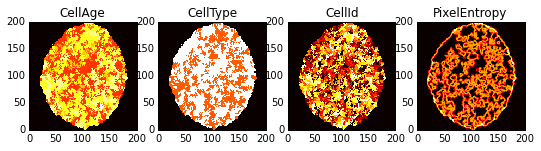

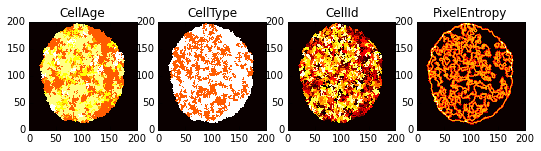

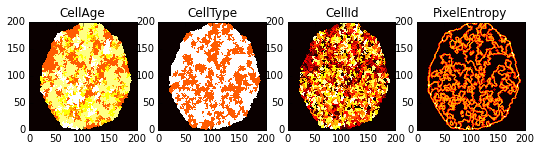

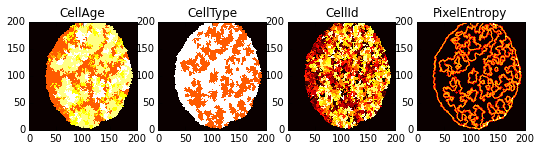

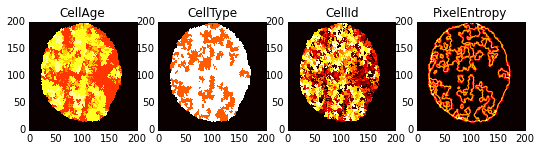

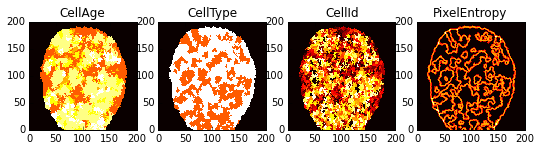

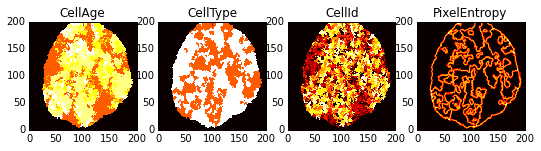

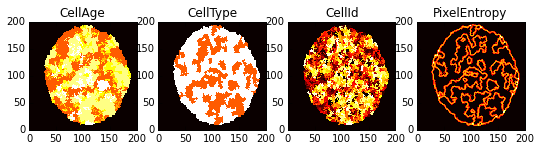

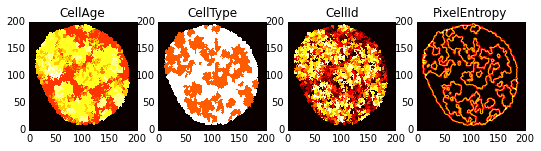

In [177]:
dpi = 90. # pixel per inch 
pix_width = 800
pix_height = 300

%matplotlib inline
frame_num = -1
f_size_i = (pix_width/dpi, pix_height/dpi)

def show_fields(tumor, frame_num):
    fig, axes = plt.subplots(1, len(tumor.data_fields))
    fig.set_size_inches(f_size_i)

    for ax, (name, field) in zip(axes, tumor.data_fields.items()):
        ax.imshow(field[frame_num], cmap='hot', origin='lower', interpolation='nearest')
        ax.set_title(name, fontdict={'fontsize':12})

for tumor in tumors.values():
    diff_adh = tumor.sim_dict['energies']['CancerStemCell-NonCancerous']
    show_fields(tumor, frame_num)
    plt.savefig('{}_fields_{}.svg'.format(sim_name, diff_adh))

In [97]:
for tumor in tumors.values():
    tumor.get_idxs()
    tumor.get_cell_df()
    tumor.get_edge_df()


In [98]:
def get_entropy(tumor):

    pis = tumor.edge_df.type_diff.groupby(
        level=['t', 'srce']).apply(
        lambda df: df.sum()/float(df.size))
    
    pis.index.names = ['t', 'cell']
    tumor.cell_df['pis'] = pis
    entropy = - pis * np.log2(pis)
    tumor.cell_df['entropy'] = entropy

for tumor in tumors.values():
    get_entropy(tumor)

In [99]:
def cell_averages(tumor):
    
    
    cell_df = tumor.cell_df
    tumor.is_csc = cell_df.loc[cell_df.type == 1].index 
    tumor.is_npc = cell_df.loc[cell_df.type == 2].index

    tumor.n_csc = (cell_df.type == 1).groupby(level='t').sum()
    tumor.n_npc = (cell_df.type == 2).groupby(level='t').sum()

    tumor.area_csc = cell_df.area.loc[tumor.is_csc].groupby(level='t').apply(np.mean)
    tumor.area_npc = cell_df.area.loc[tumor.is_npc].groupby(level='t').apply(np.mean)
    
    tumor.entropy_csc = cell_df.entropy.loc[tumor.is_csc].groupby(level='t').apply(np.mean)
    tumor.entropy_npc = cell_df.entropy.loc[tumor.is_npc].groupby(level='t').apply(np.mean)
    
    tumor.pis_csc = cell_df.pis.loc[tumor.is_csc].groupby(level='t').apply(np.mean)
    tumor.pis_npc = cell_df.pis.loc[tumor.is_npc].groupby(level='t').apply(np.mean)
    
    

In [100]:
tumors.keys()

[0, 1, 2, 3, 4, 5, 6, 7, 8]

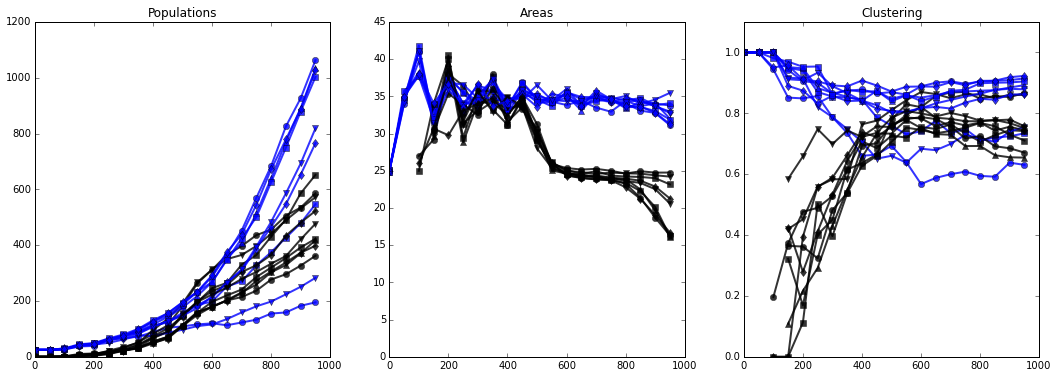

In [101]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(18, 6)


for tumor, style in zip(tumors.values(), ['o-', 's-', 'v-', 'd-', '^-', 'o-', 's-', 'v-', 'd-', '^-']):
    cell_averages(tumor)

    axes[0].plot(tumor.n_csc.index, tumor.n_csc, 'b'+style, lw=2, alpha=0.8)
    axes[0].plot(tumor.n_npc.index, tumor.n_npc, 'k'+style, lw=2, alpha=0.8)
    axes[0].set_title('Populations')

    axes[1].plot(tumor.area_csc.index, tumor.area_csc, 'b'+style, lw=2, alpha=0.8)
    axes[1].plot(tumor.area_npc.index, tumor.area_npc, 'k'+style, lw=2, alpha=0.8)
    axes[1].set_title('Areas')
    axes[1].set_ylim(0, 45)
    

    axes[2].plot(tumor.pis_csc.index, tumor.pis_csc, 'b'+style, lw=2, alpha=0.8)
    axes[2].plot(tumor.pis_npc.index, tumor.pis_npc, 'k'+style, lw=2, alpha=0.8)
    axes[2].set_title('Clustering')
    axes[2].set_ylim(0, 1.1)
    
    

In [102]:
data_dict = {}

data_dict['diff_adh'] = np.array([tumor.sim_dict['energies']['CancerStemCell-NonCancerous']
                                  for tumor in tumors.values()])

data_dict['pop_frac'] = np.array([tumor.n_npc.iloc[-1] / (tumor.n_csc.iloc[-1] +
                                                          tumor.n_npc.iloc[-1])
                                  for tumor in tumors.values()])

data_dict['area_frac'] = np.array([tumor.area_npc.iloc[-1] / tumor.area_csc.iloc[-1]
                                   for tumor in tumors.values()])

data_dict['clustering_npc'] = np.array([tumor.pis_npc.iloc[-7:].mean()
                                        for tumor in tumors.values()])

data_dict['clustering_csc'] = np.array([tumor.pis_csc.iloc[-7:].mean()
                                        for tumor in tumors.values()])


collected[sim_name] = pd.DataFrame.from_dict(data_dict)
collected[sim_name].set_index('diff_adh', inplace=True)

collected[sim_name].sort_index(inplace=True)


In [103]:
df = collected[sim_name]

In [104]:
df

,area_frac,clustering_csc,clustering_npc,pop_frac
diff_adh,,,,
1.0,0.733234,0.607231,0.860144,0.750320
1.5,0.679813,0.735734,0.738134,0.543786
2.0,0.682635,0.717982,0.858236,0.669006
2.5,0.645299,0.841157,0.775545,0.405741
3.0,0.503302,0.875617,0.688370,0.287879
3.5,0.523953,0.905341,0.718319,0.254035
4.0,0.507322,0.887361,0.742220,0.296634
4.5,0.628217,0.861765,0.779316,0.368056
5.0,0.533433,0.905376,0.757324,0.279298


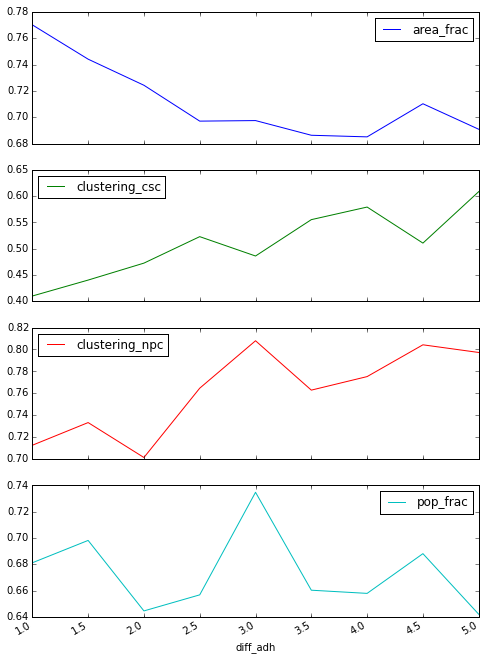

In [73]:

axes = df.plot(subplots=True, figsize=(8, 12))

In [56]:
with pd.get_store('simulations.h5') as sim_store:
    for name, data in collected.items():
        sim_store[name] = data

In [7]:
collected = {}
with pd.get_store('simulations.h5') as sim_store:
    for key in sim_store.keys():
        collected[key] = sim_store[key]

In [8]:
collected.keys()

['/Sim2_ParameterScan_after_ar02',
 '/Sim2_ParameterScan_none_ar_04',
 '/Sim2_ParameterScan_before_ar04',
 '/Sim2_ParameterScan_none_ar02',
 '/Sim2_ParameterScan_before_ar02']

In [124]:
res_

LinregressResult(slope=-0.017417515284514032, intercept=0.86051209971150966, rvalue=-0.29155264737822467, pvalue=0.44653355817994889, stderr=0.0215988206817402)

Sim2_ParameterScan_before_ar04, CSC: 0.066 ± 0.014, p = 0.003
Sim2_ParameterScan_before_ar04, NPC: -0.019 ± 0.014, p = 0.223
Sim2_ParameterScan_none_ar02, CSC: 0.044 ± 0.015, p = 0.019
Sim2_ParameterScan_none_ar02, NPC: 0.012 ± 0.010, p = 0.293
Sim2_ParameterScan_after_ar02, CSC: 0.097 ± 0.022, p = 0.003
Sim2_ParameterScan_after_ar02, NPC: -0.010 ± 0.006, p = 0.108
Sim2_ParameterScan_none_ar_04, CSC: 0.042 ± 0.008, p = 0.002
Sim2_ParameterScan_none_ar_04, NPC: 0.023 ± 0.006, p = 0.008
Sim2_ParameterScan_before_ar02, CSC: 0.088 ± 0.050, p = 0.121
Sim2_ParameterScan_before_ar02, NPC: -0.017 ± 0.022, p = 0.447


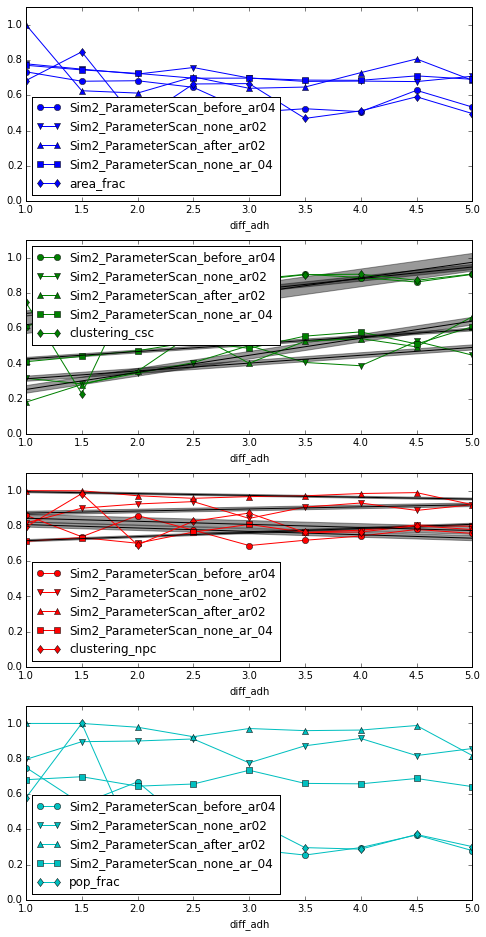

In [126]:
fig, axes = plt.subplots(4, 1, figsize=(8, 16))

styles = {key:s for key, s in zip(collected, 'ov^sd')}
xs = np.linspace(1, 5, 30)

for key, df in collected.items():
    axes = df.plot(subplots=True, ax=axes, style='-'+styles[key], legend=True)
    for ax in axes:
        l = ax.lines[-1]
        l.set_label(key)
        
    res_ = linregress(df.index, df.clustering_csc)
    axes[1].plot(xs, res_.intercept + xs * res_.slope, 'k-')
    axes[1].fill_between(xs, res_.intercept - res_.stderr + xs * res_.slope,  
                         res_.intercept + res_.stderr + xs * res_.slope, alpha=0.4, color='k')
    print('{}, CSC: {:.3f} ± {:.3f}, p = {:.3f}'.format(key, res_.slope, res_.stderr, res_.pvalue))
    res_ = linregress(df.index, df.clustering_npc)
    axes[2].plot(xs, res_.intercept + xs * res_.slope, 'k-')
    axes[2].fill_between(xs, res_.intercept - res_.stderr + xs * res_.slope,  
                         res_.intercept + res_.stderr + xs * res_.slope, alpha=0.4, color='k')
    print('{}, NPC: {:.3f} ± {:.3f}, p = {:.3f}'.format(key, res_.slope, res_.stderr, res_.pvalue))
        
for ax in axes:
    ax.set_ylim(0, 1.1)

plt.savefig('sim_report.svg')

In [115]:
from scipy.stats import linregress
for df in collected.values():
    
    res_ = linregress(df.index, df.clustering_csc)
    axes[1].plot(xs, res_.intercept + xs * res_.slope)
    axes[1].fill_between(xs, res_.intercept - res_.stderr + xs * res_.slope,  
                         res_.intercept + res_.stderr + xs * res_.slope)
    
    res_ = linregress(df.index, df.clustering_npc)
    axes[2].plot(xs, res_.intercept + xs * res_.slope)
    axes[2].fill_between(xs, res_.intercept - res_.stderr + xs * res_.slope,  
                         res_.intercept + res_.stderr + xs * res_.slope)

/home/guillaume/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


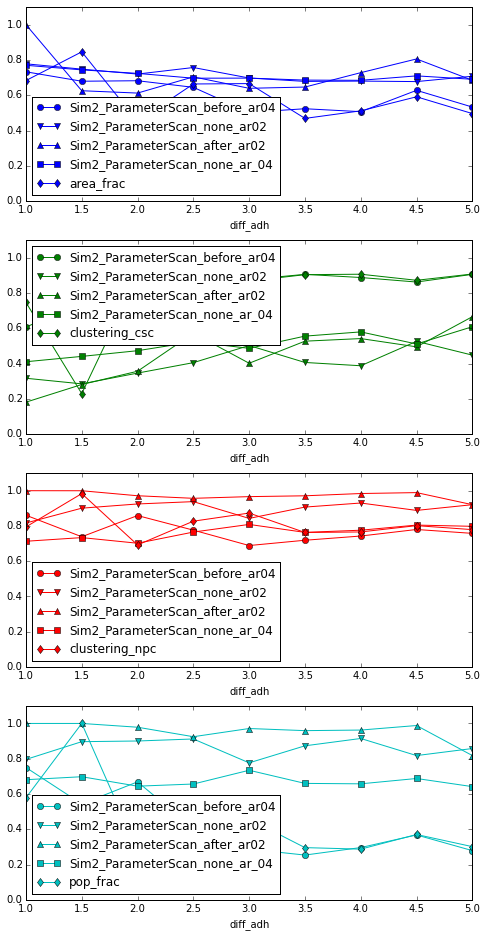

In [116]:
fig

In [ ]:
ax.fill_between()

In [113]:
res_.s

LinregressResult(slope=0.088495039484830715, intercept=0.53111104139672283, rvalue=0.55429899072459909, pvalue=0.12144849715403985, stderr=0.050224417763314509)

In [125]:
!ls

CompuCell3D simulations Importer.ipynb	simulations.h5
File Upload Widget.ipynb


In [123]:
collected

{'Sim2_ParameterScan_after_ar02':           area_frac  clustering_csc  clustering_npc   pop_frac
 diff_adh                                                      
 1.0        1.000489        0.180929        0.999134        inf
 1.5        0.625988        0.280927        0.998871        inf
 2.0        0.612692        0.356138        0.970522  45.800000
 2.5        0.704578        0.571598        0.955966  12.307692
 3.0        0.639727        0.401519        0.965557  33.857143
 3.5        0.646856        0.526592        0.970249  23.550000
 4.0        0.728369        0.541324        0.983120  25.705882
 4.5        0.806069        0.494433        0.988329  84.400000
 5.0        0.685040        0.665353        0.919907   4.495652,
 'Sim2_ParameterScan_before_ar02':           area_frac  clustering_csc  clustering_npc  pop_frac
 diff_adh                                                     
 1.0        0.683671        0.746207        0.793773  1.373932
 1.5        0.846349        0.229313   

In [15]:
from skimage import io

In [16]:
ls ../../InVivo_data/Data_neuroblasr/


im1_cells.tif  im1_types.tif  im2_data.csv   im3_cells.tif  im3_types.tif
im1_data.csv   im2_cells.tif  im2_types.tif  im3_data.csv


In [17]:
in_vivo_path = '../../InVivo_data/Data_neuroblasr/'
segmented = io.imread(os.path.join(in_vivo_path, 'im1_cells.tif'))
types = io.imread(os.path.join(in_vivo_path, 'im1_types.tif'))
data = pd.read_csv(os.path.join(in_vivo_path, 'im1_data.csv'), sep='\t')

In [50]:
data.index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            214, 215, 216, 217, 218, 219, 220, 221, 222, 223],
           dtype='int64', length=224)

In [54]:
labels = (segmented[:, :, 0]).copy().astype(np.int)

for ix, cell in data.iterrows():
    x, y = int(cell.center_x_cells), int(cell.center_y_cells)
    color = segmented[y, x]
    labels[np.product(segmented == color, axis=2)] = ix
labels = morphology.erosion(labels, morphology.square(3))    

In [55]:
rag = graph.rag_mean_color(segmented, labels)

In [56]:
rag.edges()

[(0, 64),
 (0, 187),
 (0, 53),
 (2, 112),
 (2, 81),
 (2, 180),
 (2, 86),
 (2, 212),
 (2, 252),
 (2, 191),
 (3, 192),
 (3, 64),
 (3, 198),
 (3, 135),
 (3, 40),
 (3, 170),
 (3, 203),
 (3, 14),
 (3, 16),
 (3, 18),
 (3, 118),
 (3, 55),
 (3, 152),
 (3, 58),
 (8, 129),
 (8, 86),
 (8, 139),
 (8, 148),
 (8, 26),
 (8, 27),
 (8, 157),
 (8, 44),
 (8, 45),
 (8, 176),
 (8, 50),
 (8, 184),
 (8, 61),
 (8, 64),
 (8, 66),
 (8, 214),
 (8, 220),
 (8, 96),
 (8, 226),
 (8, 105),
 (8, 119),
 (8, 252),
 (9, 40),
 (9, 105),
 (9, 226),
 (9, 86),
 (9, 49),
 (13, 225),
 (13, 17),
 (13, 33),
 (13, 70),
 (13, 113),
 (13, 139),
 (13, 44),
 (13, 81),
 (13, 179),
 (13, 22),
 (13, 185),
 (13, 132),
 (13, 36),
 (13, 223),
 (14, 64),
 (14, 37),
 (14, 200),
 (14, 170),
 (14, 140),
 (14, 205),
 (14, 104),
 (14, 86),
 (14, 250),
 (14, 150),
 (14, 133),
 (16, 197),
 (16, 203),
 (16, 53),
 (16, 55),
 (16, 152),
 (17, 67),
 (17, 197),
 (17, 230),
 (17, 139),
 (17, 140),
 (17, 203),
 (17, 22),
 (17, 250),
 (17, 126),
 (18, 49)

In [51]:
from skimage import morphology

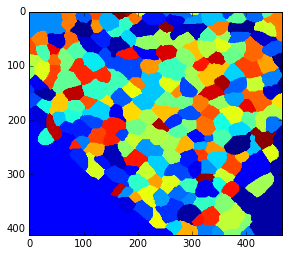

In [58]:
fig, ax = plt.subplots()
ax.imshow(labels)

In [18]:
from scipy.spatial import Delaunay

In [21]:
points = data[['center_x_cells', 'center_y_cells']]
delaunay = Delaunay(points)

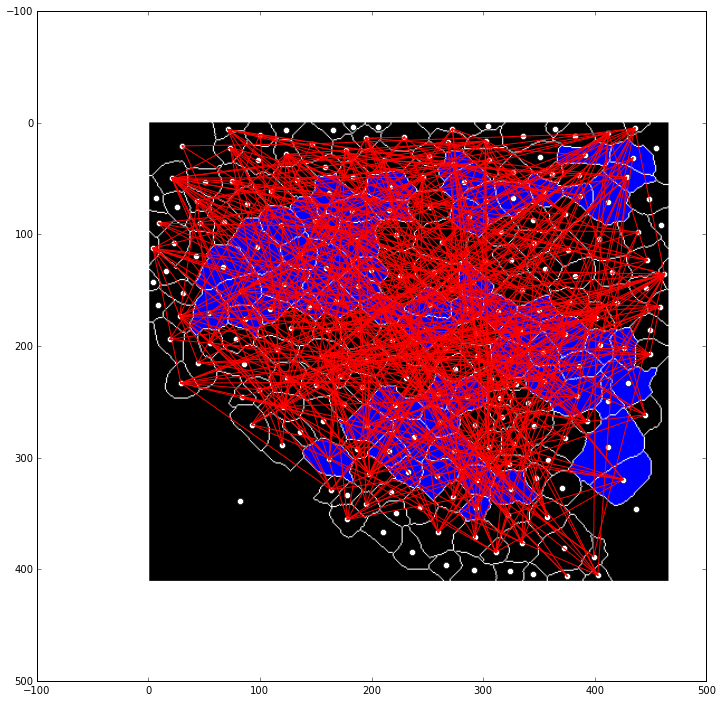

In [57]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(types)
ax.plot(data.center_x_cells, 
        data.center_y_cells, 'wo')
for srce, trgt in rag.edges_iter():
    try:
        ax.plot(data.loc[[srce, trgt], 'center_x_cells'],
                data.loc[[srce, trgt], 'center_y_cells'], 'r-')
    except:
        continue

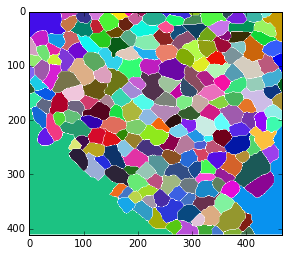

In [23]:
plt.imshow(segmented)

In [35]:
edges = []
for s in delaunay.simplices:
    edges.append([(s[0], s[1]),
                  (s[0], s[2]),
                  (s[1], s[2])])

In [25]:
types.shape, segmented.shape

((412, 467, 3), (412, 467, 3))

In [26]:
np.unique(types)

array([  0, 255], dtype=uint8)

In [27]:
types.shape

(412, 467, 3)

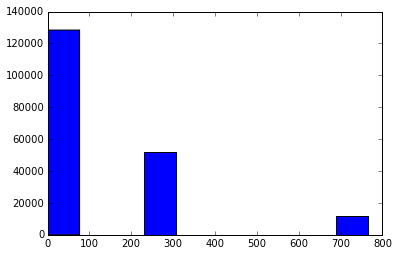

In [33]:
fig, ax =  plt.subplots()

h = ax.hist(types.sum(axis=2).ravel())

In [34]:
255*3

765

In [ ]:
segemented